In [46]:
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import  train_test_split
from sklearn.neighbors import KNeighborsClassifier, RadiusNeighborsClassifier,NearestCentroid
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
sns.set()

Загрузка данных первого сета.

In [47]:
abalone = pd.read_csv('abalone.data',names=["Sex","Length","Diameter","Height","Whole weight","Shucked weight","Viscera weight","Shell weight","Rings"])
#Смотрим основные параметры.

Оцениваем что в дата-сете есть, и с чем прийдется иметь дело.

In [48]:
abalone.head(100)

,Sex,Length,Diameter,Height,Whole weight,Shucked weight,Viscera weight,Shell weight,Rings
0,M,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150,15
1,M,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070,7
2,F,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210,9
3,M,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155,10
4,I,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055,7
...,...,...,...,...,...,...,...,...,...
95,M,0.665,0.535,0.195,1.6060,0.5755,0.3880,0.480,14
96,M,0.535,0.435,0.150,0.7250,0.2690,0.1385,0.250,9
97,M,0.470,0.375,0.130,0.5230,0.2140,0.1320,0.145,8
98,M,0.470,0.370,0.130,0.5225,0.2010,0.1330,0.165,7


Cмотрим насколько однородны данные и сколько пропущенных элементов в тех или иных столбцах.

In [49]:
abalone.count()

Sex               4177
Length            4177
Diameter          4177
Height            4177
Whole weight      4177
Shucked weight    4177
Viscera weight    4177
Shell weight      4177
Rings             4177
dtype: int64

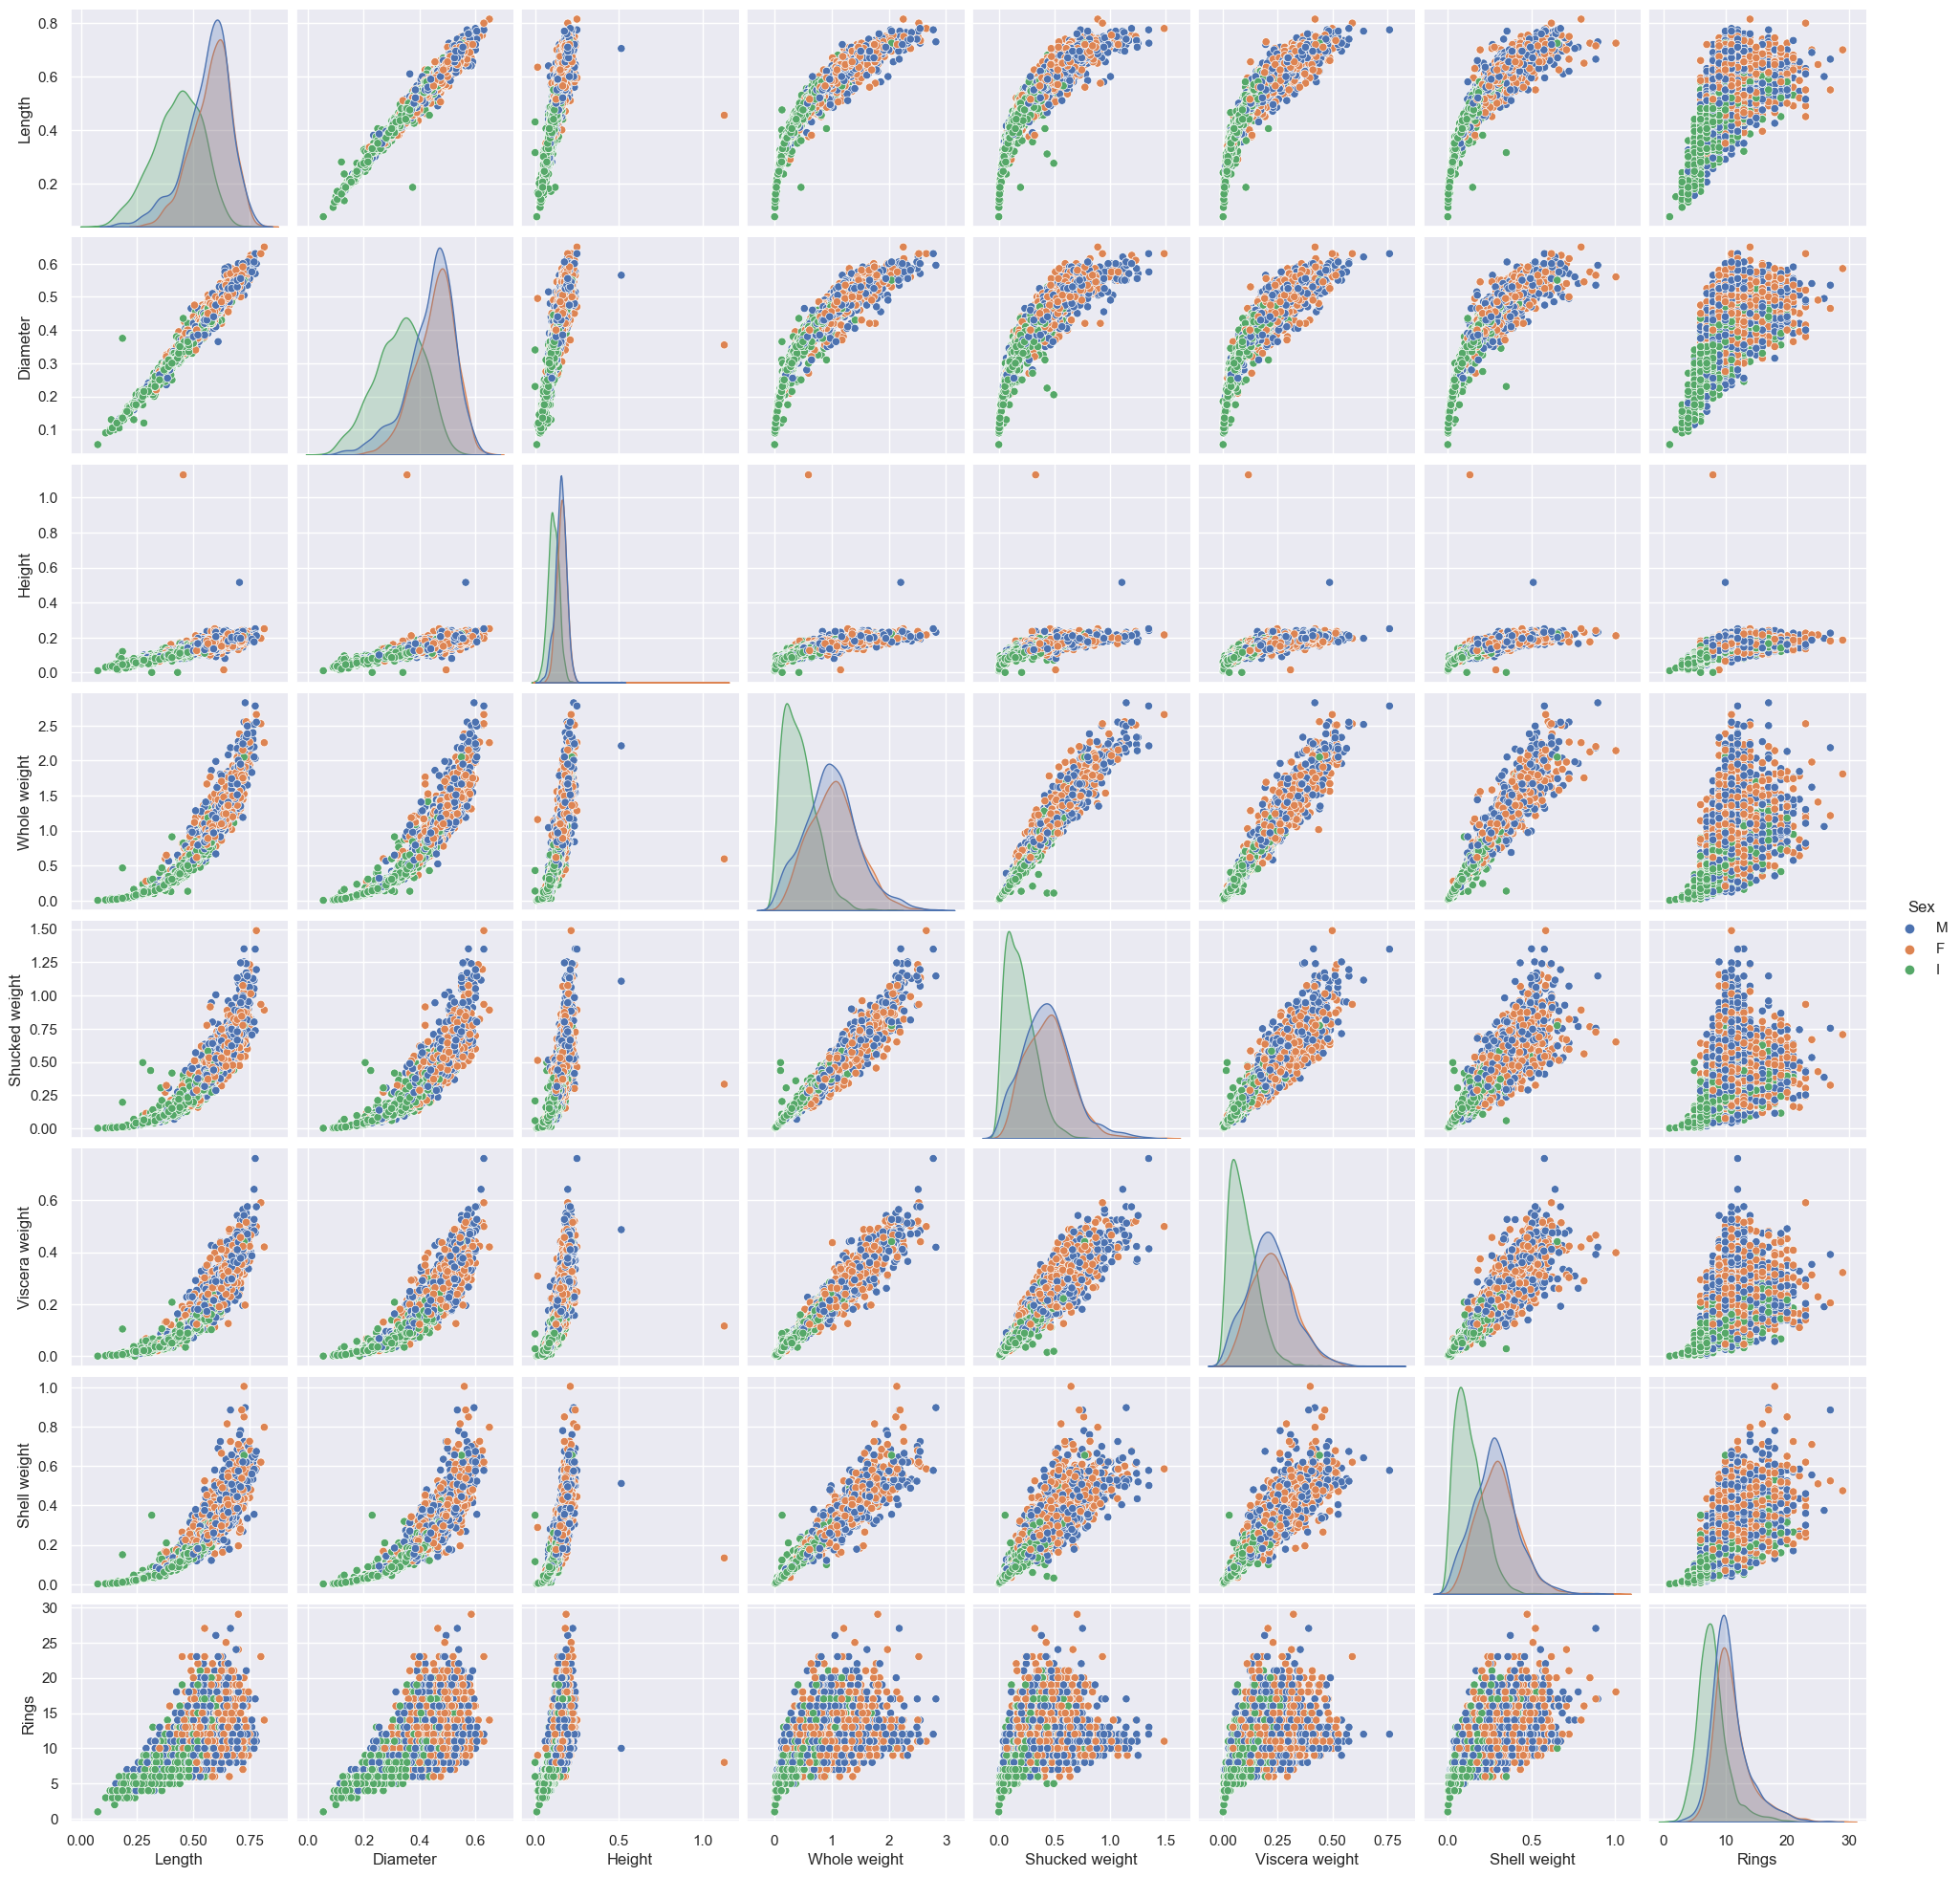

In [50]:
sns.pairplot(abalone,hue="Sex");

В процентном соотношении.

In [51]:
for col in abalone.columns:
    pct_missing = np.mean(abalone[col].isnull())
    print(f'{col} - {round(pct_missing * 100, 5)}     min: {abalone[col].min()}     max:{abalone[col].max()}')

Sex - 0.0     min: F     max:M
Length - 0.0     min: 0.075     max:0.815
Diameter - 0.0     min: 0.055     max:0.65
Height - 0.0     min: 0.0     max:1.13
Whole weight - 0.0     min: 0.002     max:2.8255
Shucked weight - 0.0     min: 0.001     max:1.4880000000000002
Viscera weight - 0.0     min: 0.0005     max:0.76
Shell weight - 0.0     min: 0.0015     max:1.005
Rings - 0.0     min: 1     max:29


In [52]:
abalone.drop(columns=["Shucked weight","Viscera weight","Shell weight","Length"], inplace=True)

In [53]:
abalone["amount"] = abalone["Diameter"]*abalone["Height"]*abalone["Whole weight"]
abalone.drop(columns=["Diameter","Height","Whole weight"], inplace=True)

Пропущенных значений нет, как и заявлялось в описании. Странность есть в минимальном значении столбца "chlorides", исправим:

In [54]:
abalone.describe()

,Rings,amount
count,4177.000000,4177.000000
mean,9.933684,0.062847
std,3.224169,0.058284
min,1.000000,0.000000
25%,8.000000,0.017575
50%,9.000000,0.048399
75%,11.000000,0.091532
max,29.000000,0.643055


Из таблицы резко выбиваются значения "free sulfur dioxide":289 и "total sulfur dioxide": 400. Проверим не ошибочные ли это данные.

<AxesSubplot:xlabel='Sex', ylabel='amount'>

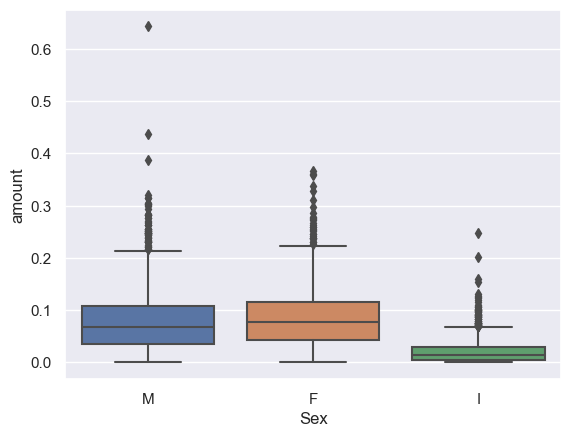

In [55]:
sns.boxplot(x="Sex", y="amount", data=abalone)

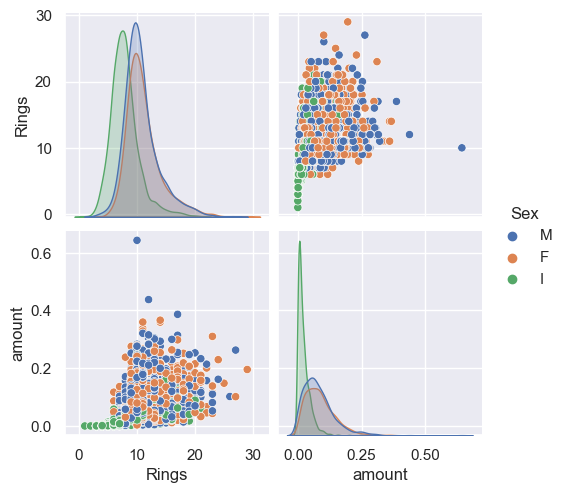

In [56]:
sns.pairplot(abalone,hue="Sex");

In [57]:
target_I_MF_bef_enc = np.where(abalone["Sex"]!="I","MF","I")
encoder = LabelEncoder()
encoder.fit(target_I_MF_bef_enc)
target_I_MF = encoder.transform(target_I_MF_bef_enc)

In [58]:
for target,encoded in zip(target_I_MF_bef_enc,target_I_MF):
    print(target,"      ",encoded)

MF        1
MF        1
MF        1
MF        1
I        0
I        0
MF        1
MF        1
MF        1
MF        1
MF        1
MF        1
MF        1
MF        1
MF        1
MF        1
I        0
MF        1
MF        1
MF        1
MF        1
I        0
MF        1
MF        1
MF        1
MF        1
MF        1
MF        1
MF        1
MF        1
MF        1
MF        1
MF        1
MF        1
MF        1
MF        1
MF        1
MF        1
MF        1
MF        1
MF        1
MF        1
I        0
I        0
I        0
I        0
MF        1
MF        1
I        0
MF        1
I        0
MF        1
MF        1
MF        1
MF        1
MF        1
MF        1
MF        1
I        0
MF        1
MF        1
MF        1
MF        1
MF        1
MF        1
MF        1
MF        1
MF        1
MF        1
I        0
MF        1
MF        1
MF        1
MF        1
MF        1
MF        1
MF        1
MF        1
MF        1
MF        1
MF        1
MF        1
MF        1
MF        1
MF  

Словарь кодировки получился таков {"I":0, "MF":1}

In [59]:
scaler = preprocessing.MinMaxScaler()
abalone_I_MF = scaler.fit_transform(abalone.drop(columns=["Sex"]))

In [60]:
datasets= {"train":{},"validation":{},"test":{}}
datasets["train"]["data"], test_val_data, datasets["train"]["target"], test_val_target = train_test_split(abalone_I_MF, target_I_MF, train_size=0.718218817334, shuffle=True)
print(datasets["train"]["data"].shape)
datasets["test"]["data"], datasets["validation"]["data"], datasets["test"]["target"], datasets["validation"]["target"] = train_test_split(test_val_data, test_val_target, test_size=0.849617672047, shuffle=True)
print(datasets["validation"]["data"].shape)

(3000, 2)
(1000, 2)


In [61]:
knn = KNeighborsClassifier()
knn.fit(datasets["train"]["data"],datasets["train"]["target"])
rnc = RadiusNeighborsClassifier(radius=3) #smallest possible radius
rnc.fit(datasets["train"]["data"],datasets["train"]["target"])
nearc = NearestCentroid()
nearc.fit(datasets["train"]["data"],datasets["train"]["target"])

NearestCentroid()

Сравним какая модель лучше себя покажет на валидационных данных, вычислив среднеквадратическую ошибку для каждой.

In [62]:
predictions = knn.predict(datasets["validation"]["data"])
mse = mean_squared_error(datasets["validation"]["target"], predictions)
print("MSE for knn: {}".format(mse))

predictions = rnc.predict(datasets["validation"]["data"])
mse = mean_squared_error(datasets["validation"]["target"], predictions)
print("MSE for rnc: {}".format(mse))

predictions = nearc.predict(datasets["validation"]["data"])
mse = mean_squared_error(datasets["validation"]["target"], predictions)
print("MSE for nearc: {}".format(mse))

MSE for knn: 0.201
MSE for rnc: 0.311
MSE for nearc: 0.231


Как видно лучше всего справляется модель KNeighborsClassifier, её и возьмём за основу.

Посмотрим какая ошибка будет на тестовой части данных.

In [63]:
predictions = knn.predict(datasets["test"]["data"])
mse = mean_squared_error(datasets["test"]["target"], predictions)
print("MSE: {}".format(mse))

MSE: 0.1807909604519774


Попробуем прогнать нашу же модель KNeighborsClassifier через подборку лучших гиперпараметров.

In [64]:
parameters = {"n_neighbors":(3,4,5,6,7,8,9),"weights":("uniform","distance"),"algorithm":("ball_tree","kd_tree","brute"),"p":[1,2]}
clf = GridSearchCV(KNeighborsClassifier(), parameters)
clf.fit(datasets["train"]["data"],datasets["train"]["target"])

GridSearchCV(estimator=KNeighborsClassifier(),
             param_grid={'algorithm': ('ball_tree', 'kd_tree', 'brute'),
                         'n_neighbors': (3, 4, 5, 6, 7, 8, 9), 'p': [1, 2],
                         'weights': ('uniform', 'distance')})

Получаем такой результат

In [65]:
prediction_I_MF_val = clf.predict(datasets["validation"]["data"])
mse = mean_squared_error(datasets["validation"]["target"], prediction_I_MF_val)
print("MSE: {}".format(mse))

MSE: 0.197


In [66]:
prediction_I_MF_test = clf.predict(datasets["test"]["data"])
mse = mean_squared_error(datasets["test"]["target"], prediction_I_MF_test)
print("MSE: {}".format(mse))

MSE: 0.1751412429378531


Для дальнейшей идентификации возьмём часть начального датасета в которых признак "Sex": "M","F"

In [67]:
abalone_M_F = abalone[abalone["Sex"]!="I"]
abalone_M_F["Sex"].value_counts()

M    1528
F    1307
Name: Sex, dtype: int64

In [68]:
target_M_F_bef_enc = abalone_M_F["Sex"]
abalone_M_F.drop(columns=["Sex"],inplace=True)
encoder_M_F = LabelEncoder()
encoder_M_F.fit(target_M_F_bef_enc)
target_M_F = encoder_M_F.transform(target_M_F_bef_enc)

C:\Users\Monya\AppData\Local\Programs\Python\Python37\lib\site-packages\pandas\core\frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [69]:
for target,encoded in zip(target_M_F_bef_enc,target_M_F):
    print(target,"      ",encoded)

M        1
M        1
F        0
M        1
F        0
F        0
M        1
F        0
F        0
M        1
M        1
F        0
F        0
M        1
F        0
M        1
M        1
M        1
F        0
F        0
F        0
F        0
F        0
M        1
M        1
M        1
M        1
F        0
M        1
F        0
F        0
M        1
F        0
F        0
F        0
M        1
F        0
F        0
M        1
F        0
F        0
M        1
M        1
F        0
M        1
F        0
M        1
M        1
F        0
M        1
M        1
F        0
M        1
M        1
M        1
F        0
F        0
F        0
M        1
F        0
F        0
M        1
F        0
F        0
M        1
F        0
F        0
F        0
F        0
M        1
F        0
M        1
M        1
F        0
M        1
M        1
F        0
F        0
M        1
M        1
M        1
F        0
M        1
M        1
M        1
M        1
M        1
F        0
M        1
M        1
M        1

Словарь кодировки получился таков {"F":0, "M":1}

In [70]:
datasets_M_F= {"train":{},"validation":{},"test":{}}
datasets_M_F["train"]["data"], test_val_data, datasets_M_F["train"]["target"], test_val_target = train_test_split(abalone_M_F, target_M_F, train_size=0.718218817334, shuffle=True)
print(datasets_M_F["train"]["data"].shape)
datasets_M_F["test"]["data"], datasets_M_F["validation"]["data"], datasets_M_F["test"]["target"], datasets_M_F["validation"]["target"] = train_test_split(test_val_data, test_val_target, test_size=0.849617672047, shuffle=True)
print(datasets_M_F["validation"]["data"].shape)

(2036, 2)
(679, 2)


Подбираем модель справляющуюся наилучше

In [71]:
knn_M_F = KNeighborsClassifier()
knn_M_F.fit(datasets_M_F["train"]["data"],datasets_M_F["train"]["target"])
rnc_M_F = RadiusNeighborsClassifier(radius=3) #smallest possible radius
rnc_M_F.fit(datasets_M_F["train"]["data"],datasets_M_F["train"]["target"])
nearc_M_F = NearestCentroid()
nearc_M_F.fit(datasets_M_F["train"]["data"],datasets_M_F["train"]["target"])

NearestCentroid()

In [72]:
predictions = knn_M_F.predict(datasets_M_F["validation"]["data"])
mse = mean_squared_error(datasets_M_F["validation"]["target"], predictions)
print("MSE for knn: {}".format(mse))

predictions = rnc_M_F.predict(datasets_M_F["validation"]["data"])
mse = mean_squared_error(datasets_M_F["validation"]["target"], predictions)
print("MSE for rnc: {}".format(mse))

predictions = nearc_M_F.predict(datasets_M_F["validation"]["data"])
mse = mean_squared_error(datasets_M_F["validation"]["target"], predictions)
print("MSE for nearc: {}".format(mse))

MSE for knn: 0.48306332842415317
MSE for rnc: 0.4727540500736377
MSE for nearc: 0.4845360824742268


Опять лучший результат показала модель KNeighborsClassifier

In [73]:
predictions = knn_M_F.predict(datasets_M_F["test"]["data"])
mse = mean_squared_error(datasets_M_F["test"]["target"], predictions)
print("MSE for knn: {}".format(mse))

MSE for knn: 0.5166666666666667


Подбор гиперпараметров

In [74]:
parameters = {"n_neighbors":(3,4,5,6,7,8,9),"weights":("uniform","distance"),"algorithm":("ball_tree","kd_tree","brute"),"p":[1,2]}
clf_M_F = GridSearchCV(KNeighborsClassifier(), parameters)
clf_M_F.fit(datasets_M_F["train"]["data"],datasets_M_F["train"]["target"])

GridSearchCV(estimator=KNeighborsClassifier(),
             param_grid={'algorithm': ('ball_tree', 'kd_tree', 'brute'),
                         'n_neighbors': (3, 4, 5, 6, 7, 8, 9), 'p': [1, 2],
                         'weights': ('uniform', 'distance')})

In [75]:
prediction_M_F_val = clf_M_F.predict(datasets_M_F["validation"]["data"])
mse = mean_squared_error(datasets_M_F["validation"]["target"], prediction_M_F_val)
print("MSE: {}".format(mse))

MSE: 0.48306332842415317


In [76]:
prediction_M_F_test = clf.predict(datasets_M_F["test"]["data"])
mse = mean_squared_error(datasets_M_F["test"]["target"], prediction_M_F_test)
print("MSE: {}".format(mse))

MSE: 0.49166666666666664


C:\Users\Monya\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\base.py:444: UserWarning: X has feature names, but KNeighborsClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


Посчитаем метрики наших двух моделей и оценим качество их тренировки:

In [77]:
matrix_I_MF = metrics.confusion_matrix(datasets["test"]["target"], prediction_I_MF_test,labels=[0,1])
matrix_I_MF = pd.DataFrame(matrix_I_MF,columns=["Предикт I","Предик MF"],index=["Факт I","Факт MF"])
matrix_I_MF

,Предикт I,Предик MF
Факт I,38,13
Факт MF,18,108


In [78]:
matrix_M_F = metrics.confusion_matrix(datasets_M_F["test"]["target"], prediction_M_F_test,labels=[0,1])
matrix_M_F = pd.DataFrame(matrix_M_F,columns=["Предикт F","Предик M"],index=["Факт F","Факт M"])
matrix_M_F

,Предикт F,Предик M
Факт F,0,59
Факт M,0,61


In [79]:
accuracy_I_MF = metrics.accuracy_score(datasets["test"]["target"], prediction_I_MF_test)
balanced_accuracy_I_MF = metrics.balanced_accuracy_score(datasets["test"]["target"], prediction_I_MF_test)
precision_I_MF = metrics.precision_score(datasets["test"]["target"], prediction_I_MF_test)
recall_I_MF = metrics.recall_score(datasets["test"]["target"], prediction_I_MF_test)

print("Presicion fo I_MF_model: ",round(precision_I_MF,2))
print("Recall fo I_MF_model: ",round(precision_I_MF,2))
print("Accurracy fo I_MF_model: ",round(accuracy_I_MF,2))
print("Balanced accurracy fo I_MF_model: ",round(balanced_accuracy_I_MF,2))

Presicion fo I_MF_model:  0.89
Recall fo I_MF_model:  0.89
Accurracy fo I_MF_model:  0.82
Balanced accurracy fo I_MF_model:  0.8


ROC curve:

C:\Users\Monya\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


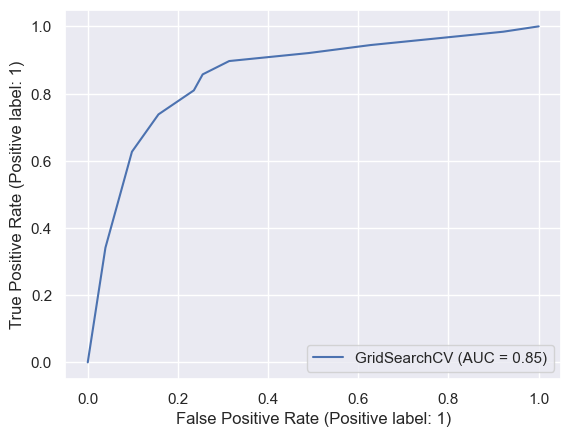

In [80]:
metrics.plot_roc_curve(clf,datasets["test"]["data"], datasets["test"]["target"])

AUC curve:

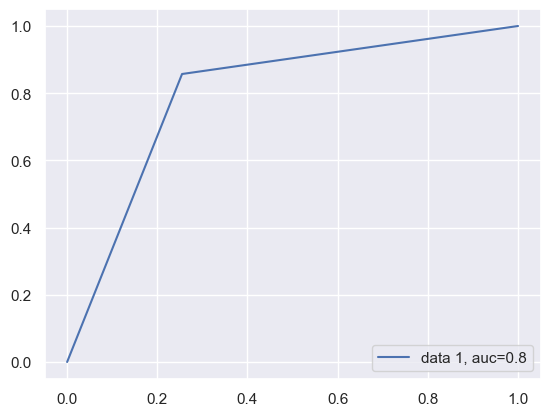

In [81]:
import matplotlib.pyplot as plt
fpr, tpr, _ = metrics.roc_curve(datasets["test"]["target"], prediction_I_MF_test)
auc = round(metrics.roc_auc_score(datasets["test"]["target"], prediction_I_MF_test),2)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()

In [82]:
accuracy_M_F = metrics.accuracy_score(datasets_M_F["test"]["target"], prediction_M_F_test)
balanced_accuracy_M_F = metrics.balanced_accuracy_score(datasets_M_F["test"]["target"], prediction_M_F_test)
precision_M_F = metrics.precision_score(datasets_M_F["test"]["target"], prediction_M_F_test)
recall_M_F = metrics.recall_score(datasets_M_F["test"]["target"], prediction_M_F_test)

print("Presicion fo M_F_model: ",round(precision_M_F,2))
print("Recall fo M_F_model: ",round(precision_I_MF,2))
print("Accurracy fo M_F_model: ",round(accuracy_M_F,2))
print("Balanced accurracy fo I_MF_model: ",round(balanced_accuracy_M_F,2))

Presicion fo M_F_model:  0.51
Recall fo M_F_model:  0.89
Accurracy fo M_F_model:  0.51
Balanced accurracy fo I_MF_model:  0.5


ROC curve:

C:\Users\Monya\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


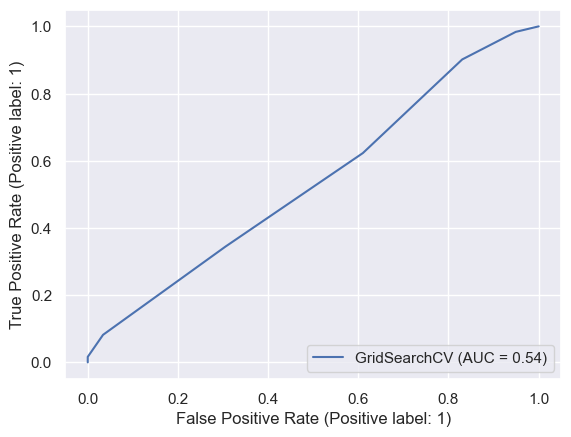

In [83]:
metrics.plot_roc_curve(clf_M_F,datasets_M_F["test"]["data"], datasets_M_F["test"]["target"])

AUC curve:

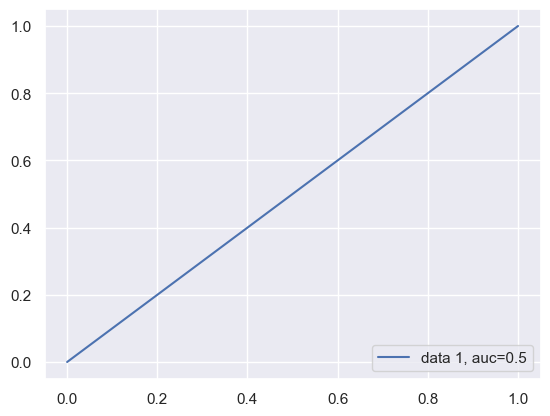

In [84]:
import matplotlib.pyplot as plt
fpr, tpr, _ = metrics.roc_curve(datasets_M_F["test"]["target"], prediction_M_F_test)
auc = round(metrics.roc_auc_score(datasets_M_F["test"]["target"], prediction_M_F_test),2)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()

Вывод:
Для разделения датасета по признаку "Sex" было предпринята попытка изначального отделения взрослых особей от детей. Модель clf была натренирована именно для этой задачи, с которой справилась удовлетворительно показав метрики
    Presicion: 0.81
    Recall: 0.81
    Accurracy: 0.8
    Balanced accurracy: 0.78
Но дальнейшее разделение взрослых особей на Male и Female для моделей классификации оказалось непосильной задачей, предположительно из-за полного отсутствия отличия в средних показателях. И метрики для воторой модели такие:
    Presicion fo M_F_model:  0.53
    Recall fo M_F_model:  0.81
    Accurracy fo M_F_model:  0.53
    Balanced accurracy fo I_MF_model:  0.5